Summary:

1. fill this in eventually. lol.

---
---
# 0. Setup
---
---

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import zerisk.Utils as utils

## Import crater data

In [2]:
import zerisk.Craters

path__datahome = utils.getPath('current','..','data','1_raw')

Craters = zerisk.Craters.Craters()
Craters.downloadData(path__datahome, overwrite=False, verbose=True)

Craters.loadData(minDiam=70, maxDiam=1000, extraInfo=True)

# Craters.getByName('Henry')

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\craters. 
To overwrite, add `overwrite=True` param.



---
---
# 1. Crustal Thickness
---
---

## 1.1. Description
[excerpt from `src/data/crustal_thickness/README.txt`]

SOURCE:
- Data is generated by the "InSight Crustal Thickness Archive" code by Mark A. Wieczorek: 
    - link: https://zenodo.org/record/6477509 (doi: 10.5281/zenodo.6477509)
- Code is supplemental to the manuscript:
    - Wieczorek, M. A., et al., InSight constraints on the global character of the Martian crust, Journal of Geophysical Research: Planets, 2022.

PARAMETERS:
- We use `make-grids.py` with parameters:
    - Reference interior model = DWThot
        - Emailed Gong about what he's using but he hasn't gotten back to me, gonna try talking to Weiczoreck at LPSC
    - Seismic thickness at InSight landing site (km) = 30
    - rho_north (kg/m3) = 2900
    - rho_south (kg/m3) = 2900
    - Grid spacing in degrees = 0.1 (see file name)

---
## 1.2. Load data

In [3]:
import zerisk.Crust
Crust = zerisk.Crust.Crust()

path__datahome = utils.getPath('current','..','data','1_raw')
Crust.downloadData(path__datahome, overwrite=False, verbose=True)

Crust.loadData(ref_interior_model_int=0)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\crustal_thickness. 
To overwrite, add `overwrite=True` param.



---
## 1.3. Example 1: Create (*fully interpolated*) crustal thickness map
i.e. all crustal thickness data points come from bilinear interpolation between the 4 points closest to the coordinate in question

Crustal thickness parameters:
- Reference interior model = 0:DWThot
- Seismic thickness at InSight landing site (km) = 30
- rho_north (kg/m3) = 2900
- rho_south (kg/m3) = 2900
- Desired grid spacing in degrees = 0.5 or 0.1 (see file name)
- Grid type = (2) list of (latitude, longitude, value, density)

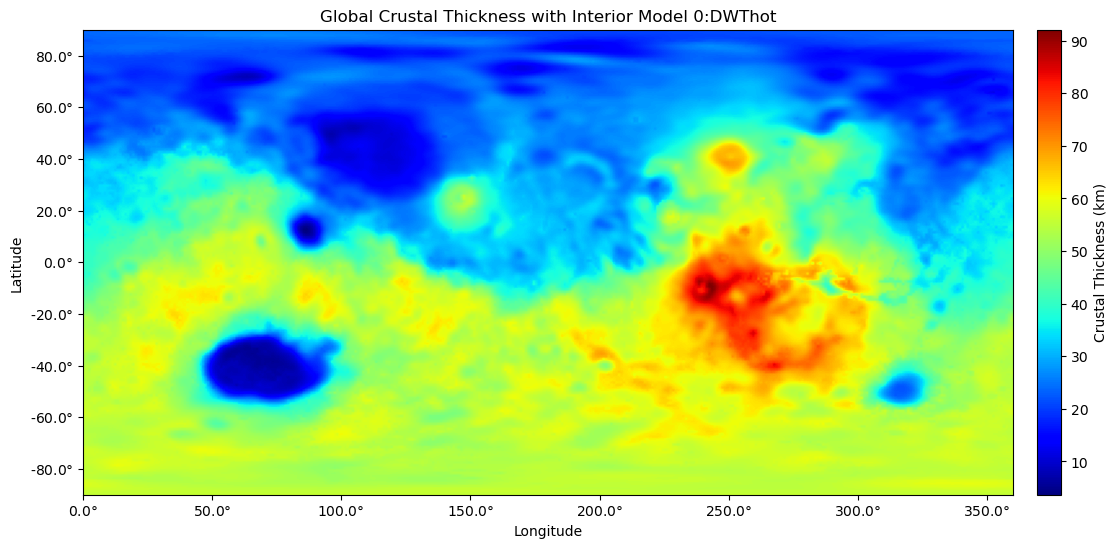

In [26]:
dat = []

clon_left = 0
clon_right = 360
lat_bottom = -90
lat_top = 90


for lat in np.arange(lat_bottom, lat_top, 1):
    newline = []
    for clon in np.arange(clon_left, clon_right, 1):
        lon = utils.clon2lon(clon)
        x = Crust.getThickness(lon, lat)
        newline.append(x)
    dat.append(newline)

    
# dat = np.asarray(dat)
# dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

fig = plt.figure(figsize=(12,10))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet', extent=[clon_left, clon_right, lat_bottom, lat_top])

ax.set_title(f'Global Crustal Thickness with Interior Model {Crust.getRefInteriorModelName_int()}:{Crust.getRefInteriorModelName_str()}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.xaxis.set_major_formatter('{x}$\degree$')
ax.yaxis.set_major_formatter('{x}$\degree$')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Crustal Thickness [km]',y=0.5)

We verify this by comparing it against the crustal thickness maps created by (1) [Gong & Wieczorek 2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JE006690), and (2) Wieczorek's crustal thickness map generator library [ctplanet](https://github.com/MarkWieczorek/ctplanet):

<img src="https://i.imgur.com/ZOoYSBo.png" width=800 />

<img src="https://i.imgur.com/YE75rQS.png" width=800 />


---
## 1.4. Example 2: Plot crustal thickness around Henry Crater

In [38]:
def plot_craterCrustalThickness_2D(identifier, scaling, spacing):

    if '-' in identifier:
        thiscrater = Craters.getByID(identifier)
    else:
        thiscrater = Craters.getByName(identifier)

    # thiscrater = Craters.getByName(crater_name)
    radius_th = Craters.km2theta(thiscrater['diam']/2)

    lon_left = thiscrater['lon']-radius_th*scaling
    lon_right = thiscrater['lon']+radius_th*scaling
    lat_bottom = thiscrater['lat']-radius_th*scaling
    lat_top = thiscrater['lat']+radius_th*scaling

    dat = []

    for lat in np.arange(lat_bottom, lat_top, spacing):
        newline = []
        for lon in np.arange(lon_left, lon_right, spacing):
            x = Crust.getThickness(lon, lat)
            newline.append(x)
        dat.append(newline)

        
    # dat = np.asarray(dat)
    # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)

    if thiscrater['name'] == '':
        name = thiscrater['id']
    else:
        name = thiscrater['name']

    ax.set_title(f'Crustal Thickness at {name} with Interior Model {Crust.getRefInteriorModelName_int()}:{Crust.getRefInteriorModelName_str()}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.xaxis.set_major_formatter('{x}$\degree$')
    ax.yaxis.set_major_formatter('{x}$\degree$')

    cbar.set_label('Crustal Thickness [km]',y=0.5)

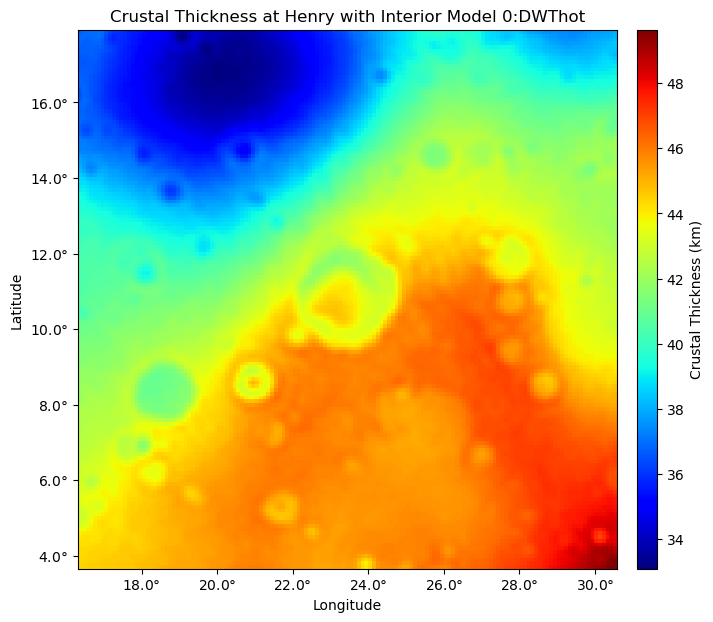

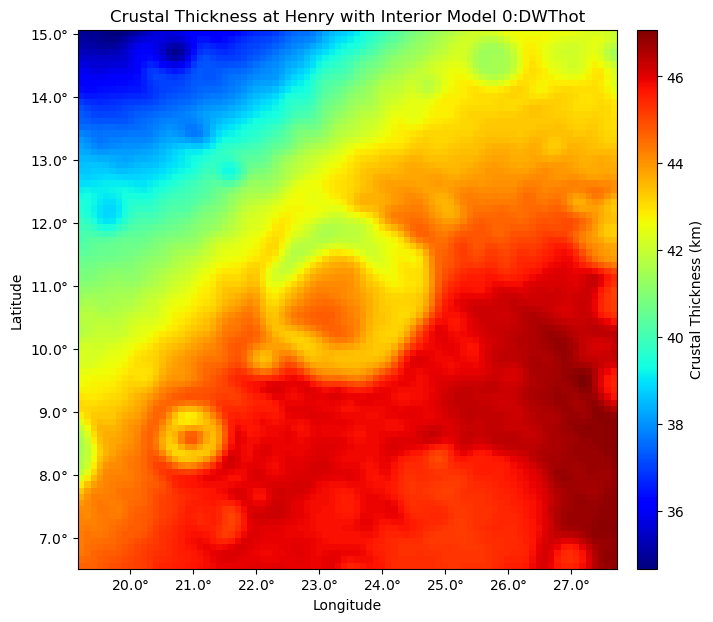

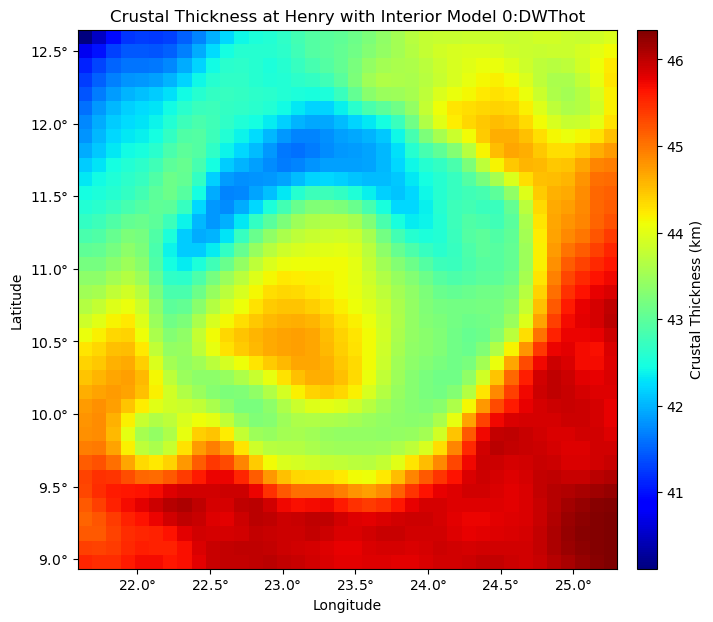

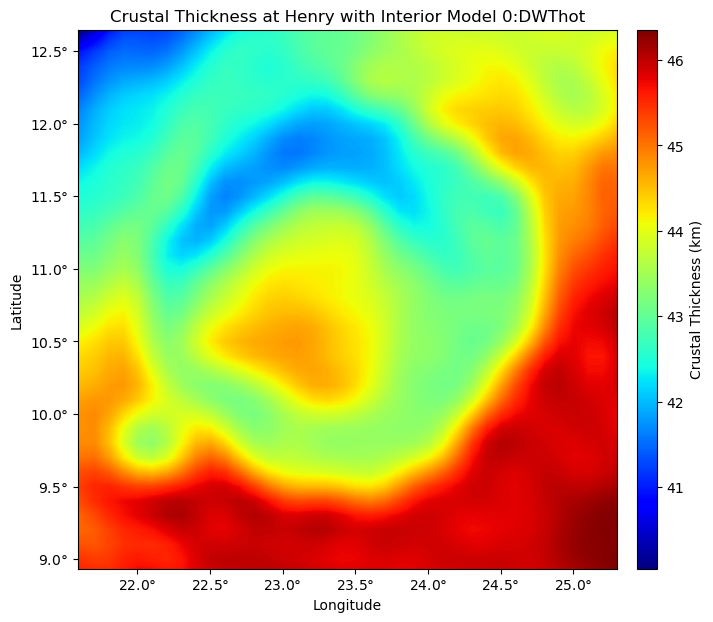

In [41]:
plot_craterCrustalThickness_2D('Henry', 5, 0.1)
plot_craterCrustalThickness_2D('Henry', 3, 0.1)
plot_craterCrustalThickness_2D('Henry', 1.3, 0.1)
plot_craterCrustalThickness_2D('Henry', 1.3, 0.01)
# should take ~30 seconds

---
## 1.5. Example 3: Henry Crater Cross-Sections

Text(0, 0.5, 'Crustal Thickness [km]')

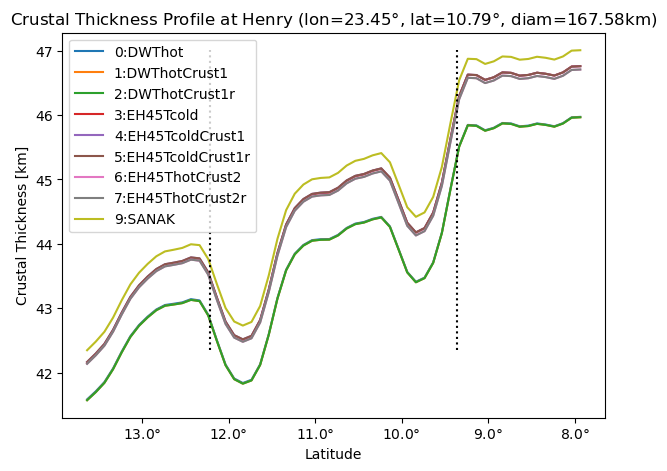

In [49]:
crater_name = 'Henry'
scaling = 2
spacing = 0.1


''' get profiles '''

thiscrater = Craters.getByName(crater_name)
radius_th = Craters.km2theta(thiscrater['diam']/2)

crater_lon_center = thiscrater['lon']
crater_lat_center = thiscrater['lat']
crater_lat_bottom = thiscrater['lat']-radius_th
crater_lat_top = thiscrater['lat']+radius_th
frame_lat_bottom = thiscrater['lat']-radius_th*scaling
frame_lat_top = thiscrater['lat']+radius_th*scaling

lat_range = np.arange(frame_lat_bottom, frame_lat_top, spacing)


meta_dat = []

for i in range(16):
    if i in Crust.invalid_ref_interior_model:
        continue
    Crust.loadData(ref_interior_model_int=i)


    dat = []
    for lat in lat_range:
        dat.append(Crust.getThickness(crater_lon_center, lat))
    dat = np.asarray(dat)


    meta_dat.append([i, dat])


''' plot '''

fig = plt.figure(figsize=(7,5))
ax = plt.axes()
for (i,dat) in meta_dat:
    lin, = ax.plot(lat_range, dat)
    lin.set_label(f'{i}:{Crust.dict_ref_interior_model[i]}')


ax.legend()
ax.invert_xaxis()

ax.vlines(x=[crater_lat_bottom, crater_lat_top], ymin=np.amin(dat), ymax=np.amax(dat), colors='k', linestyles='dotted')

if thiscrater['name'] == '':
    name = thiscrater['id']
else:
    name = thiscrater['name']

ax.set_title(f'Crustal Thickness Profile at {name} (lon={crater_lon_center:0.2f}$\degree$, lat={crater_lat_center:0.2f}$\degree$, diam={thiscrater["diam"]:0.2f}km)')
ax.set_xlabel('Latitude')
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.set_ylabel('Crustal Thickness [km]')

---
## 1.6. Example 4: Get average crustal thickness around Henry crater

In [7]:
henry = Craters.getByName('Henry')
radius_th = Craters.km2theta(henry['diam']/2)
Crust.getAvgThickness(henry['lon'], henry['lat'], radius_th)

43.66251168960871

---
## 1.7. Other craters

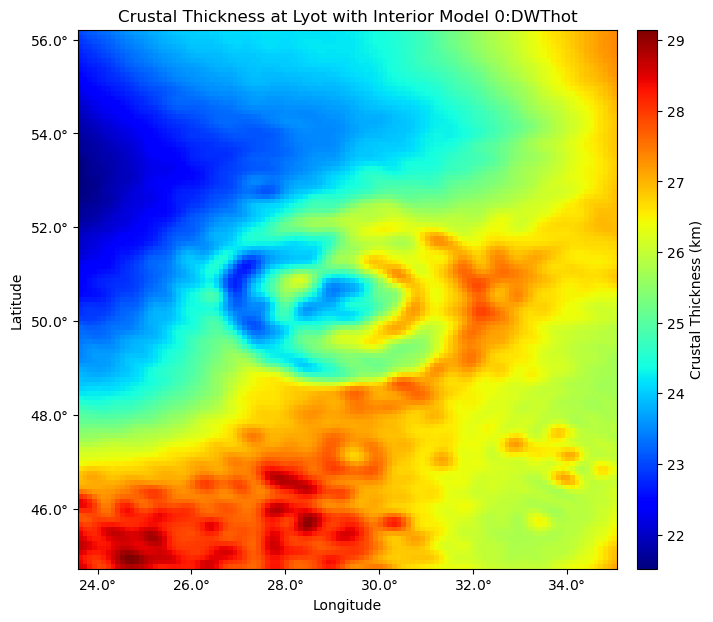

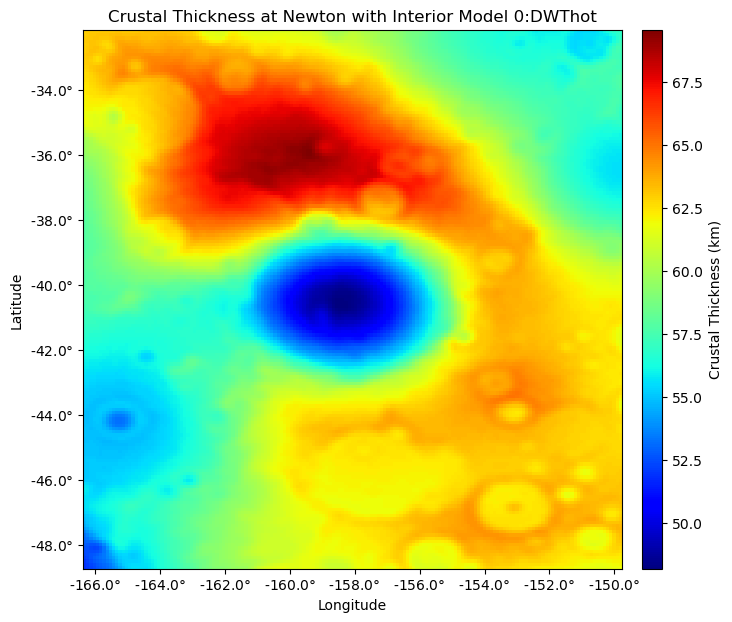

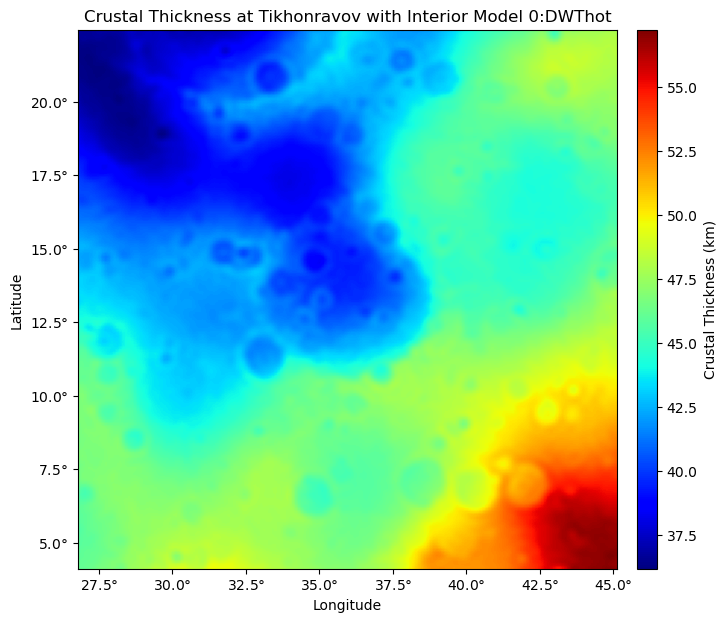

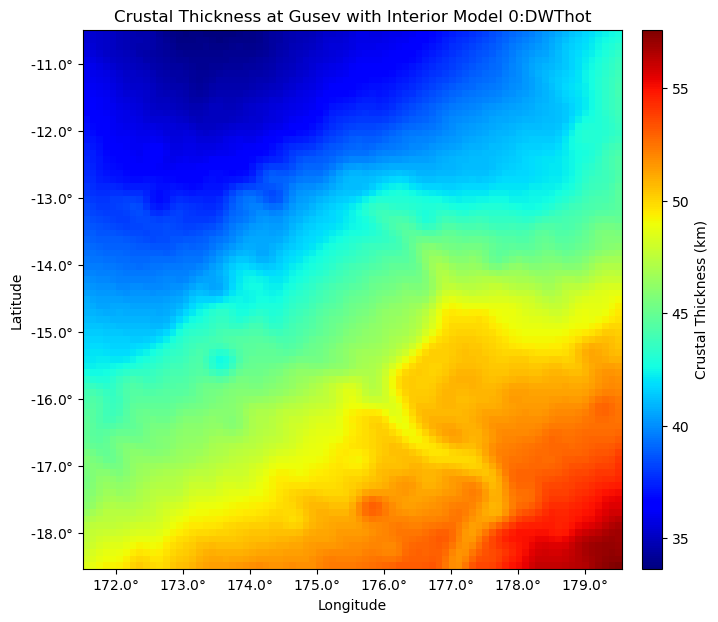

In [39]:
craters = ['Lyot', 'Newton', 'Tikhonravov', 'Gusev']

scaling = 3
spacing = 0.1

for crater_name in craters:
    plot_craterCrustalThickness_2D(crater_name, scaling, spacing)

---
---
# 2. Heat Flow
---
---

## 2.1. Description from paper

[11] The second dependent quantity in equation 2 is $C_{X}( \theta ,\phi )$, which represents the concentration by mass of element $X$ at some position. To get this value, we used $5^\circ \times 5^\circ $ chemical abundance maps of the Martian shallow subsurface derived from spectroscopy by the Mars Odyssey Gamma Ray Spectrometer (GRS) Suite \cite{temp_id_17328796999934304}. Specifically, we extract near-surface elemental concentrations of $\text{K}$ and $\text{Th}$ at the four "pixels" closest to the crater, and use weighted bilinear interpolation to estimate the concentrations at the exact coordinates of the crater. The elemental concentration of $\text{U}$ can then be calculated using a cosmochemically constant $\text{Th} /\text{U}$ mass ratio of $3.8$. At this point, it's important to note that the GRS chemical maps only represent the top tens of centimeters of Martian surface, and are therefore heavily influenced by near-surface regolith, ice, and dust deposits. However, previous studies provide strong reasons in defense of vertically homogeneous distribution of these heat producing elements given certain adjustments \cite{temp_id_17328796999934304, temp_id_9195588768017229}. To make these $\text{K} ,\text{Th} ,$ and $\text{U}$ measurements accurately represent the bulk chemistry of the entire Martian upper lithosphere, we must renormalize our values to a volatile-free basis. This is done by using the same methods and data suite to extract near-surface elemental concentrations of $\text{Cl} ,\text{H}_{2}\text{O} ,$ and $\text{S}$ at the desired coordinate, summing these to find the net concentration by mass of volatiles denoted as $V$, and then multiplying the $\text{K} ,\text{Th} ,$ and $\text{U}$ measurements by $\frac{1}{1-V}$ \ each. We note that at high latitudes, water ice saturating regolith pore space overwhelms the signatures of other elements in gamma spectra, preventing GRS instruments from collecting meaningful data. 

---
## 2.2 GRS concentrations (*fully interpolated*)

In [12]:
import zerisk.GRS
GRS = zerisk.GRS.GRS()

path__datahome = utils.getPath('current','..','data','1_raw')
GRS.downloadData(path__datahome, overwrite=False, verbose=True)

GRS.loadData()

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\GRS. 
To overwrite, add `overwrite=True` param.



### Potassium

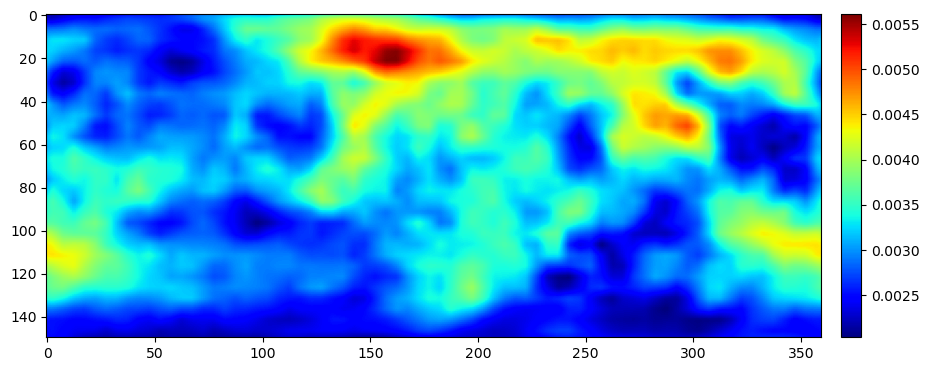

In [13]:
dat = []

for lat in np.arange(-75,75,1):
    newline = []
    for lon in np.arange(-180,180,1):
        x = GRS.getConcentration(lon, lat, 'k', normalized=False)
        newline.append(x)
    dat.append(newline)

    
dat = np.asarray(dat)
dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

Comparison with [GRS maps](https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/browse.htm).

<img src="https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/k_conc_map.jpg" width=800 />

### Thorium

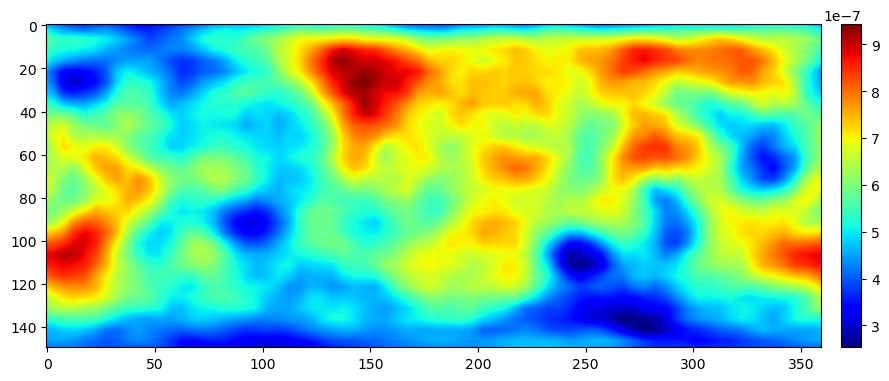

In [14]:
dat = []

for lat in np.arange(-75,75,1):
    newline = []
    for lon in np.arange(-180,180,1):
        x = GRS.getConcentration(lon, lat, 'th', normalized=False)
        newline.append(x)
    dat.append(newline)

    
dat = np.asarray(dat)
dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

Comparison with [GRS maps](https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/browse.htm).

<img src="https://pds-geosciences.wustl.edu/ody/ody-m-grs-5-elements-v1/odgm_xxxx/browse/th_conc_map.jpg" width=800 />

--- 
## 2.3. Crustal heat production per unit mass map
Calculate heat production rate in lithosphere [W/kg] at a specific coordinate/time due to decay of radiogenic heat producing elements (U238, U235, Th232, K40).

\

\begin{equation}
H( \theta ,\phi ,t) =\sum _{X} f_{X} \cdot C_{X}( \theta ,\phi ) \cdot H_{X} \cdot \left(\frac{t\cdot \ln 2}{\tau _{X}}\right) ,
\end{equation}
for $X\in \left\{^{235}\text{U} ,^{238}\text{U} ,^{232}\text{Th} ,^{40}\text{K}\right\}$, where $f_{X}$ is the isotopic fraction of element $X$; $H_{X}$ is the heat release rate constant of element $X$; and $\tau _{X}$ is the half-life of element $X$. All three of these values are well-defined constants discussed in numerous prior works \cite{temp_id_992458856131005, turcotte2014schubert, temp_id_9542413773852181}. The first dependent variable in equation 2 is $t$, which is how long ago we wish to calculate $H$ relative to present day (this is necessary because radioactive heat-producing elements will decrease in abundance from their initial concentrations over time as they decay). This $t$ is taken to be the previously determined time of formation of a crater. 

**NOTE: We are using t = 3.5 Ga**

In [15]:
import zerisk.HeatCalculator

HeatCalculator = zerisk.HeatCalculator.HeatCalculator()
path__datahome = utils.getPath('current','..','data','1_raw')
HeatCalculator.download_load_Data(path__datahome=path__datahome, overwrite=False, verbose=True)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\GRS. 
To overwrite, add `overwrite=True` param.

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\crustal_thickness. 
To overwrite, add `overwrite=True` param.



### WITHOUT volatile normalization

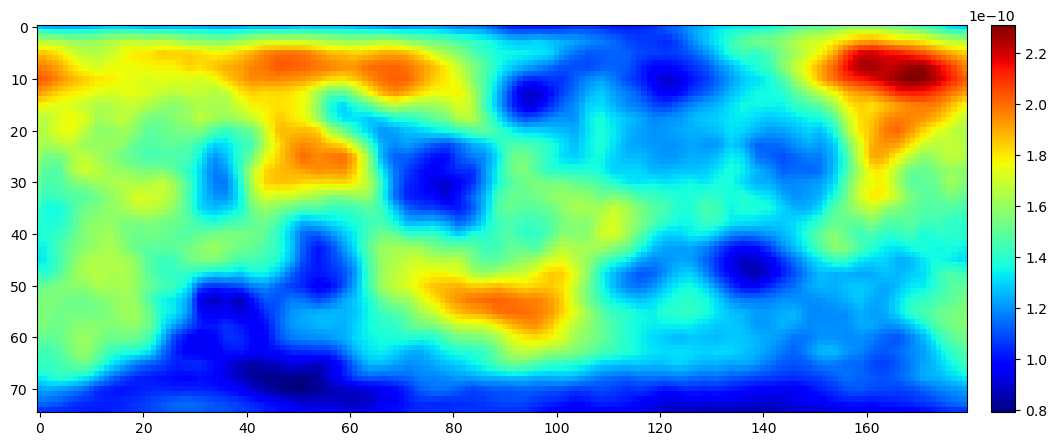

In [16]:
dat = []

for lat in np.arange(-75,75,2):
    newline = []
    for clon in np.arange(0,360,2):
        lon = utils.clon2lon(clon)
        H = HeatCalculator.calc_H(lon, lat, t=3.5e9, volatile_adjusted=False)
        x = H
        newline.append(x)
    dat.append(newline)

    
dat = np.asarray(dat)
dat = np.ma.masked_where((dat == HeatCalculator.GRS_getNanVal()), dat)

fig = plt.figure(figsize=(12,10))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

### WITH volatile normalization

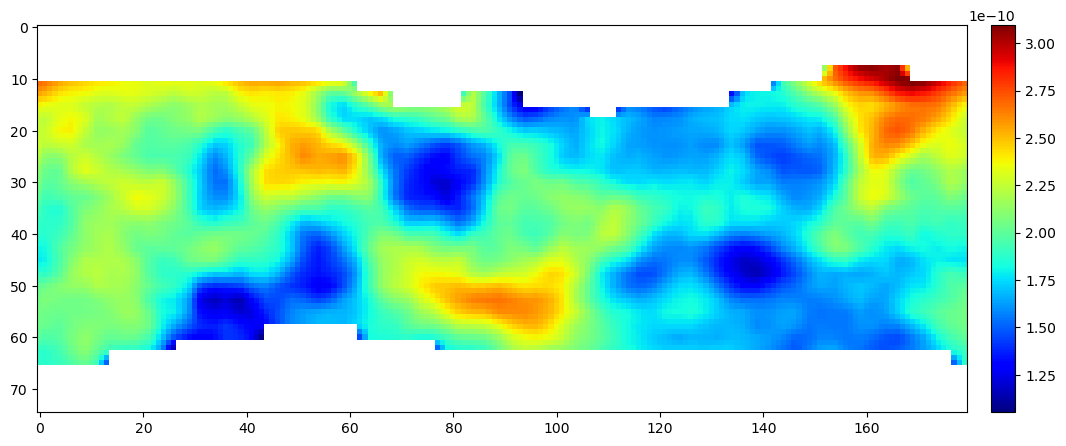

In [17]:
dat = []

for lat in np.arange(-75,75,2):
    newline = []
    for clon in np.arange(0,360,2):
        lon = utils.clon2lon(clon)
        H = HeatCalculator.calc_H(lon, lat, t=3.5e9, volatile_adjusted=True)
        x = H
        newline.append(x)
    dat.append(newline)

    
dat = np.asarray(dat)
dat = np.ma.masked_where((dat == HeatCalculator.GRS_getNanVal()), dat)
# dat = np.ma.masked_where((dat < 0), dat)


fig = plt.figure(figsize=(12,10))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

---
## 2.4. Crustal heat flow map

Watts/m^2, calculated with $\rho \cdot H(\theta,\phi,t) \cdot z_{\text{crust}}(\theta, \phi)$

- (we assume constant $\rho = 2900$)

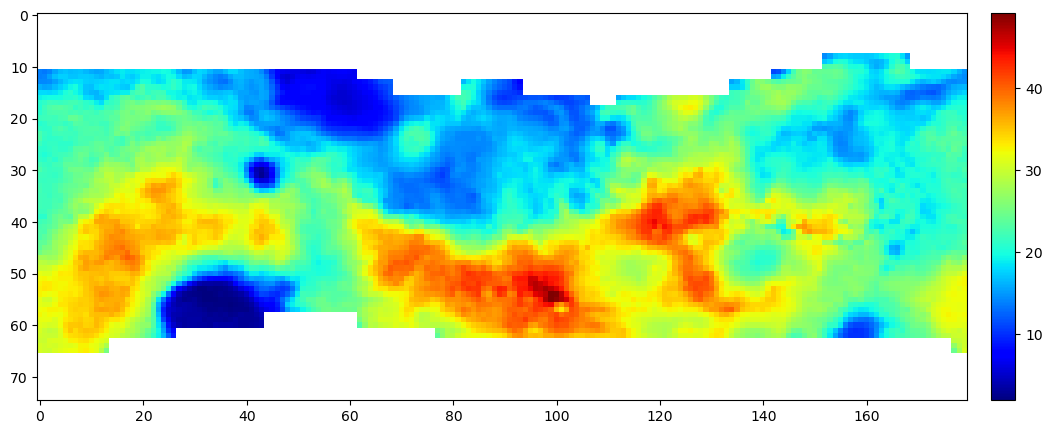

In [18]:
dat = []

for lat in np.arange(-75,75,2):
    newline = []
    for clon in np.arange(0,360,2):
        lon = utils.clon2lon(clon)
        
        rho = Crust.getDensity()
        H = HeatCalculator.calc_H(lon, lat, t=3.5e9, volatile_adjusted=True)
        z_crust = Crust.getThickness(lon, lat) * 1000
        
        x = (rho * H * z_crust)*1000 # convert to mW!!!
        newline.append(x)
    dat.append(newline)

    
dat = np.asarray(dat)
# dat = np.ma.masked_where((dat == HeatCalculator.GRS_getNanVal()), dat)
dat = np.ma.masked_where((dat < 0), dat)

fig = plt.figure(figsize=(12,10))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

### Comparison with Luju's map

(I don't provide this functionality in HeatCalculator.py because it's just for testing purposes, plus it's not my data)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\crustal_heat_flow. 
To overwrite, add `overwrite=True` param.



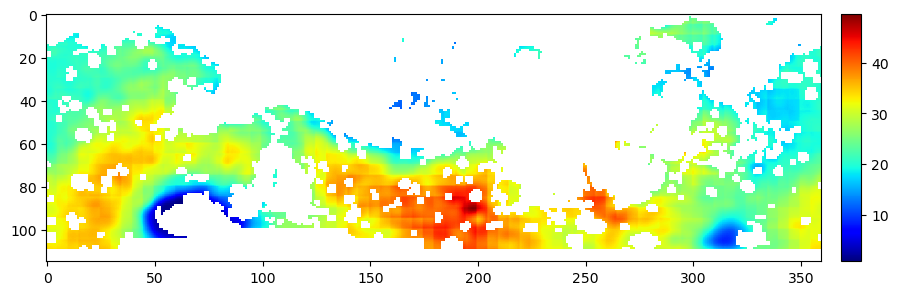

In [19]:
'''downlaod data'''
path__datahome = utils.getPath('current','..','data','1_raw')

import zerisk.DataDownloader as dd
dd.download_latest(path__datahome=path__datahome, data_name='crustal_heat_flow', url=r'https://drive.google.com/drive/folders/1npNfSX3wJzp1sRkIrSGcWt_Er2z5JPNb?usp=sharing', overwrite=False, verbose=True)


'''read+plot data'''
import scipy.io as sio
matfile = sio.loadmat(utils.getPath(path__datahome, 'crustal_heat_flow', 'HcrGRS_Hm0.mat'))
H_cr = matfile['nhf']


fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(H_cr[35:150], cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)

---
---
# 3. Temperature v Depth Profile (Curie Depths)

[9] Temperatures tends to progressively increase with proximity to the core of planetary bodies. By analytically solving the one-dimensional form of Fourier's law of heat conduction $\left( q=-k\frac{dT}{dz}\right)$ with the appropriate boundary conditions at the surface/lithosphere/mantle, we can determine the temperature as a function of depth underneath the surface in order to find Curie depths, or the depth past which no magnetization can exist in certain iron-bearing minerals. If we assume heat is exclusively produced from within the crust (i.e. the mantle is depleted in heat-producing elements \cite{temp_id_828559306242598}) and transferred from the lower mantle to the base of the lithosphere, the equation for 1D steady heat conduction with volumetric heat production is given by the following equation,

\begin{equation}
    T( z,\theta ,\phi ,t) =
        \begin{cases}
            \frac{\rho \cdot H( \theta ,\phi ,t) \cdot z}{\kappa _{c}}\left( z_{\text{crust}}( \theta ,\phi ) -\frac{z}{2}\right) +\frac{q_{b} z}{\kappa _{c}} & ,\{z< z_{\text{crust}}\}\\
            T_{0} +\frac{\rho \cdot H( \theta ,\phi ,t) \cdot z_{\text{crust}}( \theta ,\phi )^{2}}{2\kappa _{m}} +\frac{q_{b} z}{\kappa _{m}} & ,\{z >z_{\text{crust}}\}
        \end{cases}
\end{equation}


where $z$ is depth below the surface; $\rho $ is density of the crust which we set to $2,800\ \text{kg} \cdot \text{m}^{-3}$ \cite{temp_id_992458856131005}; $\kappa _{c}$ and $\kappa _{m}$ are thermal conductivities of the crust and mantle which we set to $2.5$ and $4\ \text{W} \cdot \text{m}^{-1} \cdot \text{K}^{-1}$ \cite{temp_id_06493719815818233}; $q_{b}$ is the heat flow from the lower mantle to the base of the lithosphere which we set to $15\ \text{mW}$ according to prior estimates of ancient Mars based on lithospheric deflection \cite{temp_id_828559306242598}; $T_{0}$ is a correction term to ensure continuity at the boundary between crust and mantle; and $z_{\text{crust}}( \theta ,\phi )$ is the thickness of the crust at a certain longitude/latitude as determined by gravity data \cite{temp_id_10352626906511309}. 

In [27]:
import zerisk.HeatCalculator

HeatCalculator = zerisk.HeatCalculator.HeatCalculator()
path__datahome = utils.getPath('current','..','data','1_raw')
HeatCalculator.download_load_Data(path__datahome=path__datahome, overwrite=False, verbose=True)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\GRS. 
To overwrite, add `overwrite=True` param.

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\crustal_thickness. 
To overwrite, add `overwrite=True` param.



Text(0, 0.5, 'Temperature (C)')

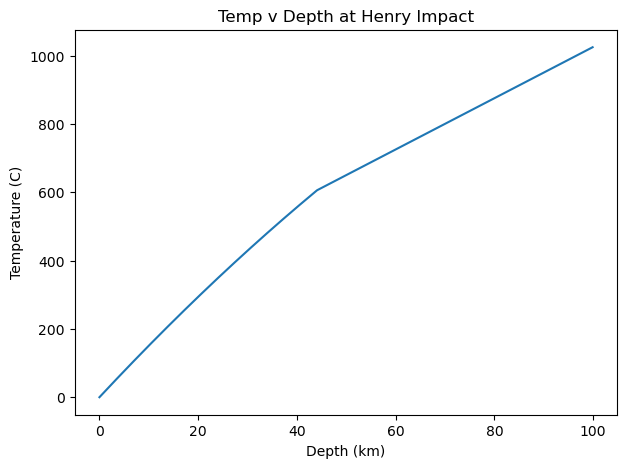

In [21]:
crater_name = 'Henry'
thiscrater = Craters.getByName(crater_name)

depths_km, temps_C = HeatCalculator.calc_TempDepthProfile(thiscrater['lon'], thiscrater['lat'], thiscrater['age'], 30, 100)

fig1 = plt.figure(figsize=(7,5))
ax1 = plt.axes()
im1 = ax1.plot(depths_km, temps_C)

ax1.set_title(f"Temp v Depth at {crater_name} Impact")
ax1.set_xlabel("Depth (km)")
ax1.set_ylabel("Temperature (C)")


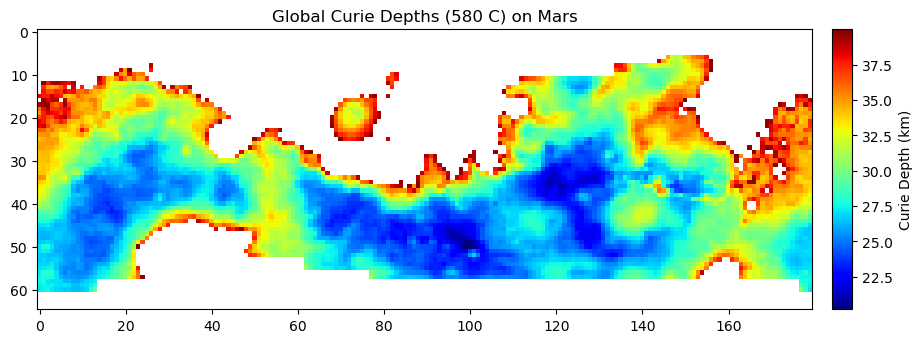

In [22]:
dat = []

for lat in np.arange(-65,65,2):
    newline = []
    for clon in np.arange(0,360,2):
        lon = utils.clon2lon(clon)
        x = HeatCalculator.calc_CurieDepths(lon, lat, t=3.5e9, q_b_mW=30, curie_temps=580, volatile_adjusted=True)
        newline.append(x)
    dat.append(newline)

    
dat = np.asarray(dat)
dat = np.ma.masked_where((dat == HeatCalculator.GRS_getNanVal()), dat)
dat = np.ma.masked_where((dat > 40), dat)


fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)

ax.set_title('Global Curie Depths (580 C) on Mars')
cbar.set_label('Curie Depth (km)',y=0.5)

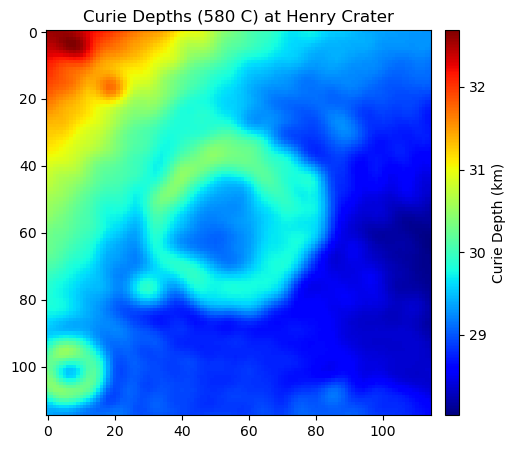

In [23]:
thiscrater = Craters.getByName('Henry')
radius_th = Craters.km2theta(thiscrater['diam']/2)
scaling = 2

dat = []

for lat in np.arange(thiscrater['lat']-radius_th*scaling,thiscrater['lat']+radius_th*scaling,0.05):
    newline = []
    for lon in np.arange(thiscrater['lon']-radius_th*scaling,thiscrater['lon']+radius_th*scaling,0.05):
        x = HeatCalculator.calc_CurieDepths(lon, lat, t=3.6e9, q_b_mW=30, curie_temps=580, volatile_adjusted=True)
        newline.append(x)
    dat.append(newline)

    
# dat = np.asarray(dat)
# dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

fig = plt.figure(figsize=(7,5))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)

ax.set_title('Curie Depths (580 C) at Henry Crater')
cbar.set_label('Curie Depth (km)',y=0.5)

---
---
# 4. Impact Demag

## 4.1. Calculation Function

Derivation [here](https://drive.google.com/file/d/1gqw-CU8_PWR1qCPvX1eCzrFIzEnVom2W/view?usp=sharing) on page 6, section 2.2.2.

In [24]:
def calc_P(diameter_km, r_km, z_km):
    
    ## unit conversions
    diameter_m = diameter_km * 1000
    r_m = r_km * 1000 # horizontal distance from impact site
    z_m = z_km * 1000 # depth from floor of crater (?)
    
    
    ## start complicated math shit -- NOTE THAT EVERYTHING IS IN SI, I.E. METERS NOT KILOMETERS!!!
    
    diam_obs = diameter_m # observed crater diameter
    diam_star = 7 * 1000 # transition diameter from simple to complex crater, assumed 7km for mars
    diam_trans = 0.7576 * (diam_obs ** 0.921) * (diam_star ** 0.079)
    # print(diam_trans / 1000)
    
    v_proj = 10 * 1000 # impact velocity, varies from 8-12 km/s, assumed 10 km/s
    g = 3.721 # surface gravity
    E = ((diam_trans * v_proj**0.09 * g**0.22)/(0.2212)) ** (1/0.26) # energy of impactor
    
    rho = 2900 # density of impactor, assumed 2900 kg/m^3 for basaltic
    r_proj = ((3 * E)/(2 * math.pi * rho * v_proj**2))**(1/3) # radius of impactor, assumed to be spherical basaltic projectile
    
    R_0 = 0.75 * r_proj # radius of isobaric core, ~70% of projectile radius
    
    C_basalt = 3.5 * 1000 # bulk speed of sound in material, assumed 3.5 km/s for kinosaki basalt
    S_basalt = 1.5 # shock parameter of material, assumed 1.5 for kinosaki basalt
    
    P_0 = 0.25 * rho * v_proj * (2*C_basalt + S_basalt*v_proj) # isobaric pressure (within isobaric core)
    
    R_direct = math.sqrt( (z_m - R_0)**2 + r_m**2 ) # distance travelled by direct pressure waves
    R_reflect = math.sqrt( (z_m + R_0)**2 + r_m**2 ) # distance travelled by reflected pressure waves
    
    tau = (R_reflect - R_direct) / C_basalt # time delay between arrival of initial and reflected pressure waves
    tau_rise = r_proj / v_proj # time rise (?)
    
    def naive_P(this_r):
        if (this_r <= R_0):
            P = P_0
        else:        
            n = 1.87 # exponential decay constant, assumed invariant with distance from impact
            # P = P_0 * ((this_r / R_0) ** -n) # for some reason this blows up ????? so i use the shahnas equation instead lol
            P = rho * (0.5*v_proj) * (C_basalt + S_basalt * (0.5*v_proj) * (R_0/this_r)**n ) * (R_0/this_r)**n
        return P
    
    if (tau > tau_rise):
        P_eff = naive_P(R_direct)
    else: # reduced peak pressure due to interference of waves
        P_eff = naive_P(R_direct) - naive_P(R_reflect) * (1 - (tau / tau_rise)) 
        
    P_eff = P_eff * 1e-9 # adjust to units of gigapascals

    return P_eff

## 4.2. Examples

In [25]:
crater_name = 'Henry'
thiscrater = Craters.getByName(crater_name)
thiscrater

{'id': '10-0-003901',
 'lon': 23.445249319999988,
 'lat': 10.79060989,
 'diam': 167.581668,
 'clon': 23.44524932,
 'name': 'Henry',
 'age': 3.6,
 'age_error': 0.03}

Text(0, 0.5, 'Depth (km)')

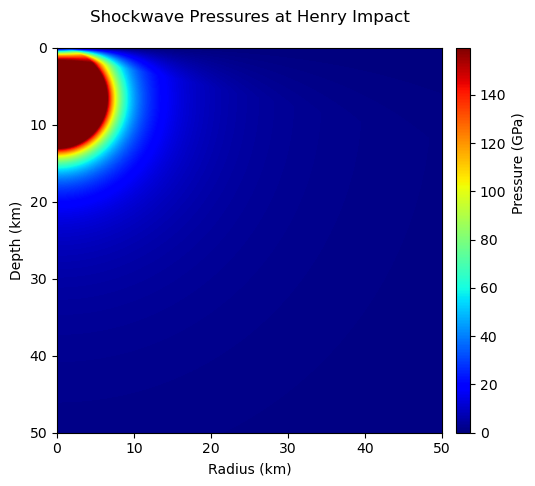

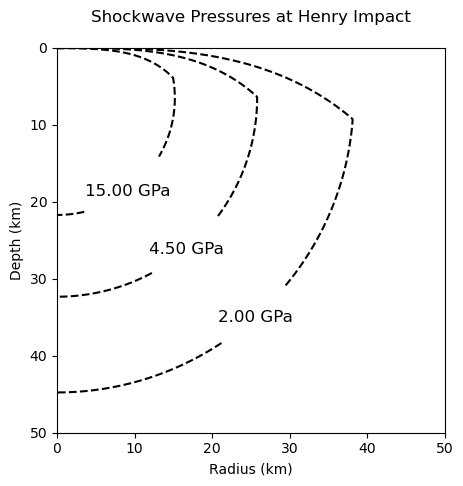

In [26]:
max_depth = 50
max_distance = 50


pressures_dat = []
for depth in np.arange(0,max_depth,0.1):
    newline = []
    for distance in np.arange(0,max_distance,0.1):
        newline.append(calc_P(thiscrater["diam"], distance, depth))
    pressures_dat.append(newline)

        
fig1 = plt.figure(figsize=(7,5))
ax1 = plt.axes()
im1 = ax1.imshow(pressures_dat, cmap='jet', extent=[0, max_distance, max_depth, 0])  # set extent to match data dimensions)
cax1 = fig1.add_axes([ax1.get_position().x1+0.02,ax1.get_position().y0,0.02,ax1.get_position().height])
cbar1 = plt.colorbar(im1, cax=cax1)

ax1.set_title(f"Shockwave Pressures at {crater_name} Impact\n")
# plt.text(x=0.45, y=0.95, s="Shockwave Pressures at Newton Impact", fontsize=14, ha="center", transform=fig.transFigure)
# plt.text(x=0.45, y=0.90, s= "Coordinates = (-158.07, -40.44); Diam = 312.43 km; Age = 4.11 Ga", fontsize=10, color='grey', ha="center", transform=fig.transFigure)
# plt.subplots_adjust(top=0.85, wspace=0.3)
ax1.set_xlabel("Radius (km)")
ax1.set_ylabel("Depth (km)")
cbar1.set_label(r'Pressure (GPa)', y=0.7)


'''-----------------------------------------------------------------------------'''


# threshold = 2
# demag_dat = [[1 if point >= threshold else 0 for point in line] for line in pressures_dat]


# fig2 = plt.figure(figsize=(7,5))
# ax2 = plt.axes()
# im2 = ax2.imshow(demag_dat, cmap='jet', extent=[0, max_distance, max_depth, 0])
# cax2 = fig2.add_axes([ax2.get_position().x1+0.02,ax2.get_position().y0,0.02,ax2.get_position().height])
# plt.colorbar(im2, cax=cax2)

# ax2.set_title(f"Shock Demagnetization Extent at {crater_name} Impact\n")
# # plt.text(x=0.45, y=0.95, s="Shock Demagnetization Extent at Newton Impact", fontsize=14, ha="center", transform=fig.transFigure)
# # plt.text(x=0.45, y=0.90, s= "Coordinates = (-158.07, -40.44); Diam = 312.43 km; Age = 4.11 Ga", fontsize=10, color='grey', ha="center", transform=fig.transFigure)
# ax2.set_xlabel("Radius (km)")
# ax2.set_ylabel("Depth (km)")


'''-----------------------------------------------------------------------------'''


fig3 = plt.figure(figsize=(5,5))
ax3 = plt.axes()
    

labels = [2, 4.5, 15]
pressures_contour = ax3.contour(pressures_dat, labels, linestyles='dashed', colors='k', extent=[0, max_distance, 0, max_depth])
ax3.invert_yaxis()


## specify label locations
locs = [(10,20),(20,30),(30,40)]
tab = ax.clabel(pressures_contour, pressures_contour.levels, inline=True, fontsize=12, manual=locs, fmt='%.2f GPa')


## do not specify label locations
# tab = ax3.clabel(pressures_contour, pressures_contour.levels, inline=True, fontsize=12, fmt='%.2f GPa')


## rotate labels
for t in tab:
    t.set_rotation(0)
    
    

ax3.set_title(f"Shockwave Pressures at {crater_name} Impact\n")
ax3.set_xlabel("Radius (km)")
ax3.set_ylabel("Depth (km)")


---
# 5. Mag Depth